# Serving Deep Learning Models

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../data/wifi_location.csv')

In [3]:
df.head()

,a_1,a_2,a_3,a_4,a_5,a_6,a_7,location
0,-64,-56,-61,-66,-71,-82,-81,0
1,-68,-57,-61,-65,-71,-85,-85,0
2,-63,-60,-60,-67,-76,-85,-84,0
3,-61,-60,-68,-62,-77,-90,-80,0
4,-63,-65,-60,-63,-77,-81,-87,0


In [4]:
df['location'].value_counts()

3    500
2    500
1    500
0    500
Name: location, dtype: int64

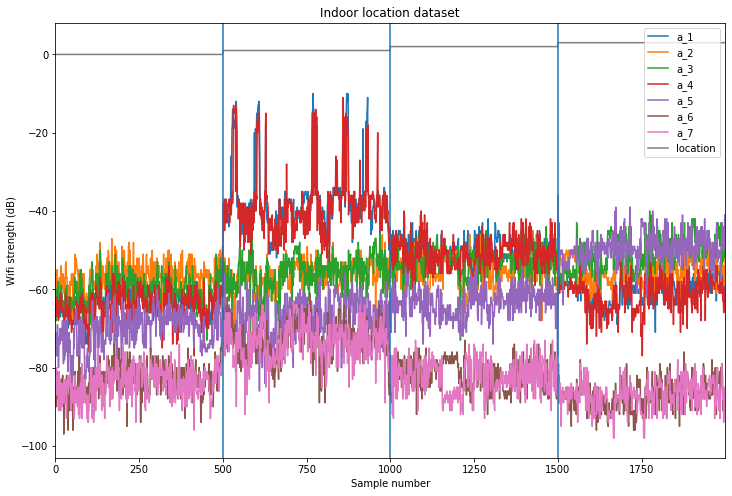

In [5]:
df.plot(figsize=(12, 8))
plt.axvline(500)
plt.axvline(1000)
plt.axvline(1500)
plt.title('Indoor location dataset')
plt.xlabel('Sample number')
plt.ylabel('Wifi strength (dB)');

In [6]:
import seaborn as sns

/home/ubuntu/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/ubuntu/miniconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


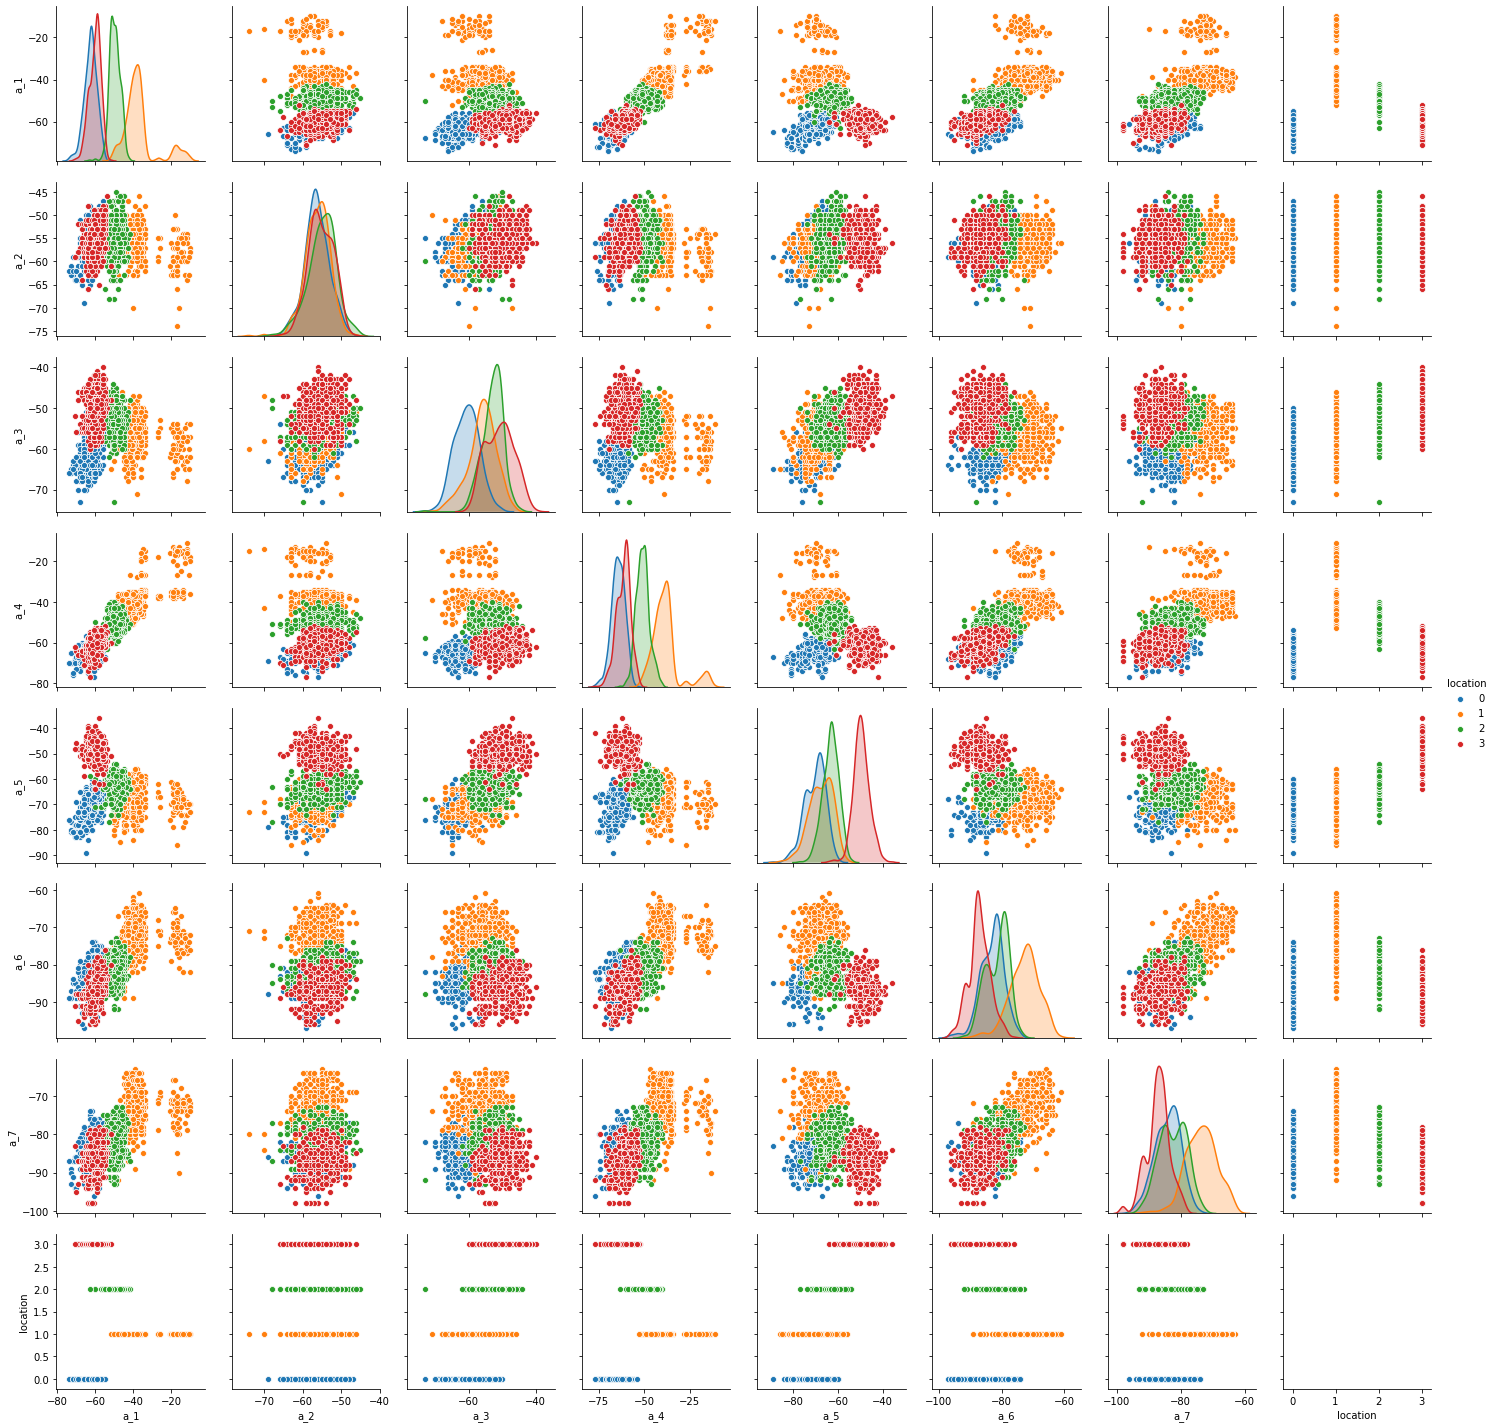

In [7]:
sns.pairplot(df, hue='location');

In [8]:
X = df.drop('location', axis=1).values
y = df['location'].values

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25,
                     random_state=0)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization

In [ ]:
inputs = Input(shape=X_train.shape[1:])
x = BatchNormalization()(inputs)
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(10, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

In [ ]:
model.summary()

In [ ]:
model.compile('adam',
              'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
h = model.fit(X_train, y_train,
              batch_size=128,
              epochs=40,
              verbose=0,
              validation_data=(X_test, y_test))

In [ ]:
pd.DataFrame(h.history).plot()
plt.ylim(0, 1);

In [ ]:
import os  # Miscellaneous operating system interfaces
import json  # JSON encoder and decoder
import shutil  # High-level file operations

In [ ]:
base_path = '/tmp/ztdl_models/wifi'
sub_path = 'flask'
version = 1

In [ ]:
from os.path import join

In [ ]:
export_path = join(base_path, sub_path, str(version))
export_path

In [ ]:
shutil.rmtree(export_path, ignore_errors=True)  # delete path, if exists
os.makedirs(export_path)  # create path

In [ ]:
json.loads(model.to_json())

In [ ]:
with open(join(export_path, 'model.json'), 'w') as fout:
    fout.write(model.to_json())

In [ ]:
model.save_weights(join(export_path, 'weights.h5'))

In [ ]:
os.listdir(export_path, )

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
with open(join(export_path, 'model.json')) as fin:
    loaded_model = model_from_json(fin.read())

In [ ]:
probas = loaded_model.predict(X_test)
probas

In [ ]:
preds = np.argmax(probas, axis=1)
preds

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, preds)

In [ ]:
loaded_model.load_weights(join(export_path, 'weights.h5'))

In [ ]:
probas = loaded_model.predict(X_test)  # class probabilities
preds = np.argmax(probas, axis=1)  # class prediction
accuracy_score(y_test, preds)  # accuracy score

## A simple deployment with Flask

In [ ]:
!cat ./model_serving/flask_serve_model.py

## Exercise 1

Open a terminal and run the script with command:

```
CUDA_VISIBLE_DEVICES="" python model_serving/flask_serve_model.py
```

Then come back here and continue

In [ ]:
import requests

In [ ]:
api_url = "http://localhost:5000/"

In [ ]:
data = X_test[:5].tolist()

In [ ]:
data

In [ ]:
payload = {'data': data}
headers = {'content-type': 'application/json'}

In [ ]:
response = requests.post(api_url,
                         data=json.dumps(payload),
                         headers=headers)

In [ ]:
response

In [ ]:
response.json()

In [ ]:
y_test[:5]

## Deployment with Tensorflow Serving

As the [documentation](https://www.tensorflow.org/serving/) says, TensorFlow Serving is a flexible, high-performance serving system for Machine Learning models, designed for production environments. TensorFlow Serving makes it easy to deploy new algorithms and experiments, while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models, but can be easily extended to serve other types of models and data.

Tensorflow Serving can accommodate both small and large deployments, and it is built for production. It is not as simple as Flask, and here we will barely scratch the surface of what it's possible with it. If you are serious about using it, we strongly recommend you take a look at the [Architecture overview](https://www.tensorflow.org/serving/architecture_overview) where many concepts like Servables, Managers and Sources are explained.

In this part of the book, we will just show you how to export a model for serving and how to ping a Tensorflow serving server. We will leave the full installation of Tensorflow serving for the end of the chapter. Installation is strongly dependent on the system you are using and is [well documented](https://www.tensorflow.org/serving/).

In [ ]:
import tensorflow as tf

In [ ]:
base_path = '/tmp/ztdl_models/wifi'
sub_path = 'tfserving'
version = 1

In [ ]:
export_path = join(base_path, sub_path, str(version))
export_path

In [ ]:
shutil.rmtree(export_path, ignore_errors=True)

In [ ]:
tf.saved_model.save(model, export_path)

In [ ]:
os.listdir(export_path)

In [ ]:
!saved_model_cli show --dir {export_path} --all

## Exercise 2

Let's pull the `tensorflow/serving` docker container:

```
docker pull tensorflow/serving:latest
```

And let' run the docker container with the following command:
```
docker run \
    -v /tmp/ztdl_models/wifi/tfserving/:/models/wifi \
    -e MODEL_NAME=wifi \
    -e MODEL_PATH=/models/wifi \
    -p 8500:8500  \
    -p 8501:8501  \
    -t tensorflow/serving
```

Where:

- `-v`: This bind mounts a volume; it tells Docker to map the internal path `/models/wifi` to the `/tmp/ztdl_models/wifi/tfserving/` in our host computer.
- `-e`: Sets environment variables, in this case, we set the `MODEL_NAME` and `MODEL_PATH` variables
- `-p`: Publishes a container's port to the host. In this case, we are publishing port 8500 (default gRPC) and 8501 (default REST).
- `-t`: Allocate a pseudo-TTY
- `tensorflow/serving` is the name of the container we are running.

Since Tensorflow 1.8, Tensorflow serving comes with both a gRPC and REST endpoints by default, so we can test our running server by simply using curl. The correct command for this is:

```
curl -d '{"signature_name": "serving_default",
          "instances": [[-62.0, -58.0, -59.0, -59.0, -67.0, -80.0, -77.0],
                        [-49.0, -53.0, -50.0, -48.0, -67.0, -78.0, -88.0],
                        [-52.0, -57.0, -49.0, -50.0, -66.0, -80.0, -80.0]]}' \
     -H "Content-Type: application/json" \
     -X POST http://localhost:8501/v1/models/wifi:predict
```

Go ahead and run that in a shell, you should receive an output that looks similar to the following:

```
{
    "predictions": [[0.997524, 1.19462e-05, 0.00171472, 0.000749083],
                    [3.40611e-06, 0.00262853, 0.997005, 0.000363284],
                    [2.52653e-05, 0.00507444, 0.993813, 0.00108718]
    ]
}
```

Once you've tested the REST API, you can test the gRPC API with the following code:

In [ ]:
from grpc import insecure_channel

In [ ]:
channel = insecure_channel('localhost:8500')

In [ ]:
channel

In [ ]:
from tensorflow_serving.apis.prediction_service_pb2_grpc import PredictionServiceStub

In [ ]:
stub = PredictionServiceStub(channel)

In [ ]:
data

In [ ]:
data_np = np.array(data)

In [ ]:
data_pb = tf.compat.v1.make_tensor_proto(data_np,
                                         dtype='float',
                                         shape=data_np.shape)

In [ ]:
data_pb

In [ ]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

In [ ]:
request = PredictRequest()

In [ ]:
request.model_spec.name = 'wifi'

In [ ]:
request.model_spec.signature_name = 'serving_default'

In [ ]:
request.inputs['input_1'].CopyFrom(data_pb)

In [ ]:
request

In [ ]:
result_future = stub.Predict.future(request, 5.0)

In [ ]:
result = result_future.result()
result

In [ ]:
scores = tf.make_ndarray(result.outputs['dense_3'])

In [ ]:
scores

In [ ]:
prediction = np.argmax(scores, axis=1)
prediction

In [ ]:
model.predict(np.array(data)).argmax(axis=1)